In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import glob
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.interpolate
import scipy.optimize

In [2]:
# guassian function
def gaussian(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# mixed gaussian function
def gaussianmix(x, *p):
    A1, mu1, sigma1, A2, mu2, sigma2 = p
    return A1*np.exp(-(x-mu1)**2/(2.*sigma1**2)) + A2*np.exp(-(x-mu2)**2/(2.*sigma2**2))

<IPython.core.display.Javascript object>


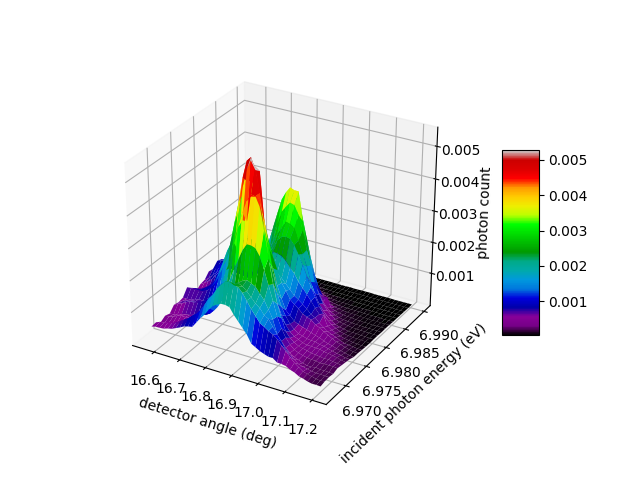

In [3]:
%matplotlib notebook
filenamelist = (glob.glob("*.txt"))
data = np.loadtxt(filenamelist[0], comments='%',dtype= float)
df = pd.DataFrame(data)
df = df.iloc[:,[0,1,15]]

# Shape data arrays
firstdat = df.iloc[0,0]
counter = 0
for i in df.iloc[:,0]:
    if firstdat == i:
        counter += 1
    else:
        break
XESpoints = counter
DCMpoints = df.shape[0] // counter  

# Scale axis to energy ranges
Xmin = df.iloc[:,1].min()
Xmax = df.iloc[:,1].max()
Ymin = df.iloc[:,0].min()
Ymax = df.iloc[:,0].max()
X = np.linspace(Xmin , Xmax , XESpoints)
Y = np.linspace(Ymin , Ymax, DCMpoints)
X, Y = np.meshgrid(X, Y)

# Reshape data to array to match the axis
Z = np.array(df.iloc[:,2]).reshape(-1,XESpoints)
Z = np.flip(Z,0)
Znorm = Z / Z.sum()

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Znorm, cmap='nipy_spectral',
                       linewidth=0, antialiased=True)
plt.xlabel('detector angle (deg)')
plt.ylabel('incident photon energy (eV)')
ax.set_zlabel('photon count')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


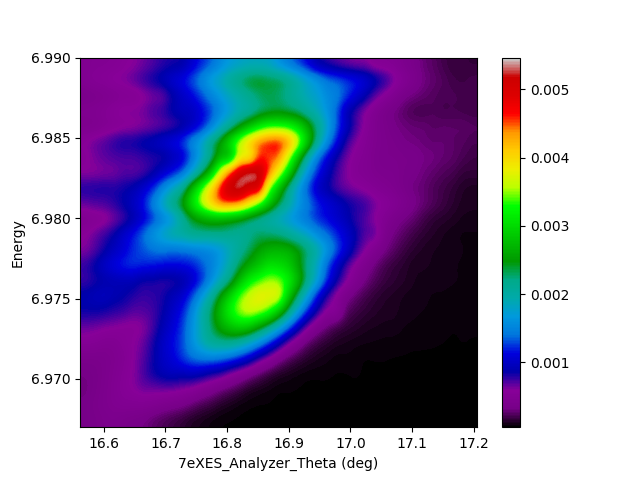

In [4]:
# Density plot of data

plt.figure(3)
plt.xlabel('7eXES_Analyzer_Theta (deg)')
plt.ylabel('Energy')
plt.imshow(Znorm, cmap= 'nipy_spectral',extent=[Xmin, Xmax, Ymin, Ymax], aspect='auto', interpolation= 'quadric')
plt.colorbar()

[1.05466412e+04 3.65182614e+00 2.87909419e+00] [9.38148750e+03 1.26424188e+01 2.52542305e+00]
(68324.6407911903, 1.0565336259205083e-06) (59386.364140500766, 1.7367519635769213e-06)


<IPython.core.display.Javascript object>


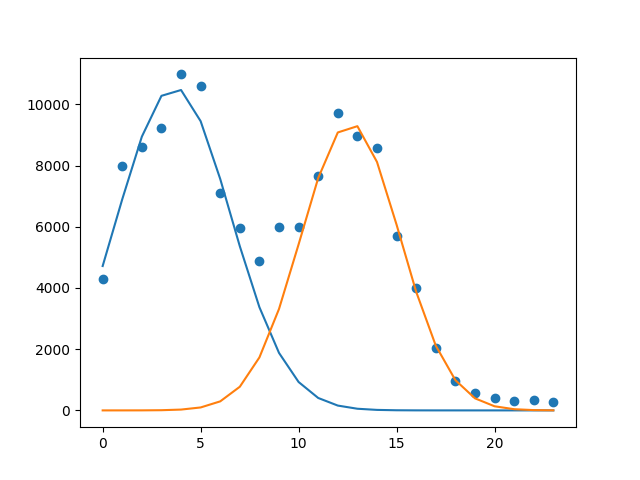

In [5]:
# Example of how data is fitted

y_data = Z[:,24]
X_data = np.arange(0, y_data.shape[0])

# p0 is the initial guess for the fitting coefficients initialize them differently so the optimization algorithm works better
p0 = [1., -1., 1.,1., -1., 1.]

# Optimize mixed gaussian function to fit data and in the end you will have 6 parameters (3 for each gaussian)
coeff, var_matrix = scipy.optimize.curve_fit(gaussianmix, X_data, y_data, p0=p0)

# Here we plot each gaussian separately  
args1 = coeff[0:3]
args2 = coeff[3:]

print(args1, args2)
g1 = gaussian(X_data, *args1)
g2 = gaussian(X_data, *args2)

area1 = scipy.integrate.quad(gaussian, X_data.min(), X_data.max(),args= (*args1,))
area2 = scipy.integrate.quad(gaussian, X_data.min(), X_data.max(),args= (*args2,))
print(area1, area2)
plt.figure(2)
plt.scatter(X_data, y_data, label='Data')
plt.plot(X_data, g1, label='Gaussian1')
plt.plot(X_data, g2, label='Gaussian2')


0
6974.592639458004 56785.55886070338
1
14198.35165988091 117341.11088145553
2
22170.17725766813 181181.41030171618
3
30230.34295746152 249405.05783034768
4
37504.2180409115 323640.41475796275
5
113795.11185882977 332864.774073536
6
127033.65680193038 411617.924050412
7
213249.88632349856 427189.6953620917
8
308097.7399428441 444936.68385483813
9
414008.19717791706 463683.27263583726
10
434306.32939052436 580402.2681469285
11
571306.7110429986 603221.8275247499
12
594992.6411489152 763970.253941814
13
643540.9281844818 924264.0736628518
14
819879.7825937199 984981.3523538535
15
852705.6420037601 1215464.3007135454
16
932227.1706051828 1416763.741919665
17
1224107.2295093315 1416763.7419196651
18
1313215.6796437562 1619911.414223028
19
1407722.685246314 1802864.272023857
20
1503289.63824492 1966171.8350317401
21
1641947.4377581077 2055324.2720694346
22
1721588.0864049112 2167865.2180554243
23
1721588.0864049317 2328296.595606493
24
1789912.727196122 2387682.9597469936
25
1842588.9638938

/home/daniel/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1910010.771571742 2523793.4658052777
28
1929902.4670570116 2559886.113786013
29
1942681.6193315666 2594934.5727204
30
1951762.943906203 2625724.48459433
31
1957946.842531079 2653078.9652202623
32
1962249.785384366 2677900.1435533995
33
34
35
36
1977373.1337633946 2681061.441408799
37
1991002.3342868832 2684309.8476004573
38
2003193.0187142799 2687767.3519124733
39
0.5729673967706882 0.42703260322931186


<IPython.core.display.Javascript object>


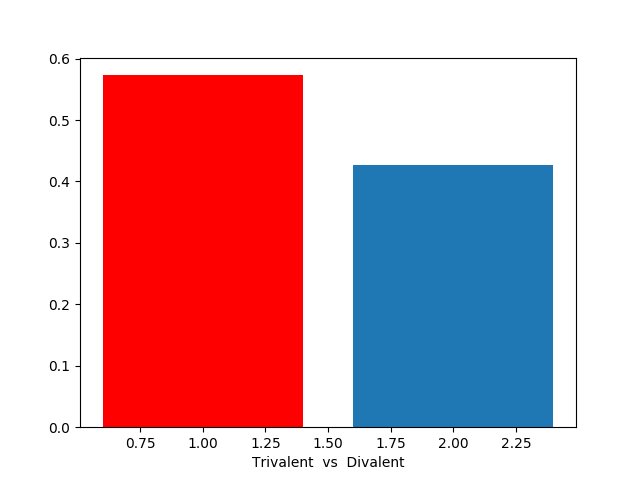

Text(0.5,0,'Trivalent  vs  Divalent')

In [6]:
# We iterate over all detector angles with guassian fit and then sum the areas under each guassian.

ox3area = 0
ox2area = 0

for i in range(0 , Z.shape[1]-1):
    print(i)
    y_data = Z[:,i]
    X_data = np.arange(0, y_data.shape[0])

    # p0 is the initial guess for the fitting coefficients initialize them differently so the optimization algorithm works better
    p0 = [1., -1., 1.,1., -1., 1.]


    # Try to fit guassians
    try:
        coeff, var_matrix = scipy.optimize.curve_fit(gaussianmix, X_data, y_data, p0=p0)
    except(RuntimeError):
        continue
 
    args1 = coeff[0:3]
    args2 = coeff[3:]
    
    # sum areas under each curve
    area1 = (scipy.integrate.quad(gaussian, X_data.min(), X_data.max(),args= (*args1,)))[0]
    area2 = (scipy.integrate.quad(gaussian, X_data.min(), X_data.max(),args= (*args2,)))[0]
    
    ox3area += area1
    ox2area += area2
    print(ox3area, ox2area)
    
    # Here we find the ratio of the areas underneith each guassian
    p2 = ox2area / (ox3area + ox2area)
    p3 = ox3area / (ox3area + ox2area)
    
    
print(p2, p3)

plt.subplots()
b2, b3 = plt.bar((1,2),(p2,p3),)
b2.set_facecolor('r')
b2.axes.set_xlabel('Trivalent  vs  Divalent')

<IPython.core.display.Javascript object>


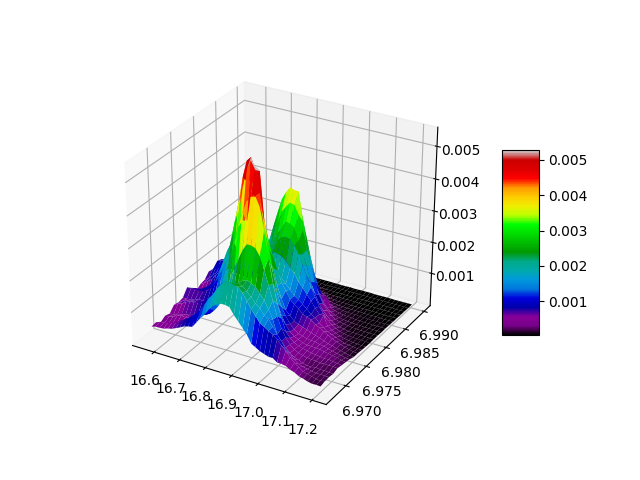

In [7]:
# animation of pressure change



filenamelist = (glob.glob("*.txt"))
data = np.loadtxt(filenamelist[0], comments='%',dtype= float)
df = pd.DataFrame(data)
df = df.iloc[:,[0,1,15]]

# Find the shape of the plot 
firstdat = df.iloc[0,0]
counter = 0
for i in df.iloc[:,0]:
    if firstdat == i:
        counter += 1
    else:
        break
XESpoints = counter
DCMpoints = df.shape[0] // counter  

# Scale axis to energy ranges
Xmin = df.iloc[:,1].min()
Xmax = df.iloc[:,1].max()
Ymin = df.iloc[:,0].min()
Ymax = df.iloc[:,0].max()
X = np.linspace(Xmin , Xmax , XESpoints)
Y = np.linspace(Ymin , Ymax, DCMpoints)
X, Y = np.meshgrid(X, Y)
# Reshape data to array to match the axis
Z = np.array(df.iloc[:,2]).reshape(-1,XESpoints)
Z = np.flip(Z,0)
Znorm = Z / Z.sum()

fig = plt.figure(8)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Znorm, cmap='nipy_spectral',
                       linewidth=0, antialiased=True)



    
# Animation function clears axis then plots new data
def animate(i):
    
    ax.clear()
    data = np.loadtxt(filenamelist[i], comments='%',dtype= float)
    df = pd.DataFrame(data)
    df = df.iloc[:,[0,1,15]]
    
    # Find the shape of the plot 
    firstdat = df.iloc[0,0]
    counter = 0
    for i in df.iloc[:,0]:
        if firstdat == i:
            counter += 1
        else:
            break
    XESpoints = counter
    DCMpoints = df.shape[0] // counter  
    
    # Scale axis to energy ranges
    Xmin = df.iloc[:,1].min()
    Xmax = df.iloc[:,1].max()
    Ymin = df.iloc[:,0].min()
    Ymax = df.iloc[:,0].max()
    X = np.linspace(Xmin , Xmax , XESpoints)
    Y = np.linspace(Ymin , Ymax, DCMpoints)
    X, Y = np.meshgrid(X, Y)
    # Reshape data to array to match the axis
    Z = np.array(df.iloc[:,2]).reshape(-1,XESpoints)
    Z = np.flip(Z,0)
    Znorm = Z / Z.sum()
    
  
    
    ax.plot_surface(X, Y, Znorm, cmap='nipy_spectral', 
                    linewidth=0, antialiased=True)
    
    
    return ax,





# Customize the z axis.

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
filenamelist = (glob.glob("*.txt"))
count = len(filenamelist)
ani = FuncAnimation(fig, animate, frames= range(0, count), blit=True, repeat = True)
plt.show()

